In [1]:
import os, pickle, copy
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import imp
import zimmer.io
imp.reload(zimmer.io)
from zimmer.io import WormData, N_worms, find_shared_neurons

from sklearn.decomposition import PCA

In [33]:
# Set path to work out of root directory
os.chdir(os.path.join(os.path.expanduser("~"), "Projects", "zimmer"))
results_dir = os.path.join("results", "11_30_16", "run002")
assert os.path.exists(results_dir)

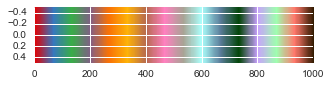

In [34]:
# Come up with a set of colors
import seaborn as sns
color_names = ["red",
               "windows blue",
               "medium green",
               "dusty purple",
               "orange",
               "amber",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "mint",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)
from hips.plotting.colormaps import harvard_colors, gradient_cmap
cmap = gradient_cmap(colors)

plt.figure(figsize=(5,1))
plt.imshow(np.linspace(0,1,1000)[None,:], cmap=cmap, aspect="auto")

In [4]:
# Load the data
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [wd.dff_deriv for wd in worm_datas]

In [5]:
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = all_neuron_names.size
print("{} neurons across all {} worms".format(N_neurons, N_worms))

477 neurons across all 5 worms


In [6]:
# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
N_shared = len(shared_neurons)
Ns_unique = Ns - N_shared

Ys_shared = []
Ys_unique = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    unique_indices = set(np.arange(wd.N))
    unique_indices -= set(shared_indices)
    unique_indices = list(unique_indices)
    
    Ys_shared.append(Y[:,shared_indices])
    Ys_unique.append(Y[:,unique_indices])


Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']


In [ ]:
# Look at the variability in neural responses across worms
plt.figure(figsize=(10,10))
N_neurons_to_plot = 5
neurons_to_plot = np.random.choice(shared_neurons, N_neurons_to_plot, replace=False)
bins = np.linspace(-0.05, 0.05, 50)
for j, neuron_to_plot in enumerate(neurons_to_plot):
    for wi, (wd, Y) in enumerate(zip(worm_datas, Ys)):
        plt.subplot(N_neurons_to_plot,N_worms,j*N_worms + wi + 1)
        shared_indices = wd.find_neuron_indices([neuron_to_plot])
        plt.hist(Y[:,shared_indices[0]], bins=bins, normed=True,
                 facecolor=colors[0], alpha=1.0, edgecolor="none")
        plt.title("{} Worm {}".format(neuron_to_plot, wi+1))
plt.tight_layout()

In [ ]:
plt.plot(Ys[0][:,0])

In [7]:
# Construct a big dataset with all neurons for each worm
datasets = []
for wd in worm_datas:
    this_dataset = []
    indices = wd.find_neuron_indices(all_neuron_names)
    for index in indices:
        if index is None:
            this_dataset.append(None)
        else:
            this_dataset.append(wd.dff_deriv[:,index][:,None])
    datasets.append(this_dataset)
                

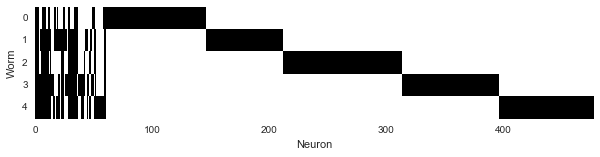

In [8]:
dsizes = [
    list(map(lambda d: np.size(d) > 1, dataset))
    for dataset in datasets
]
dsizes = np.array(dsizes)
plt.figure(figsize=(10,2))
plt.imshow(dsizes, aspect="auto", interpolation="nearest")

plt.grid("off")
plt.ylabel("Worm")
plt.xlabel("Neuron")

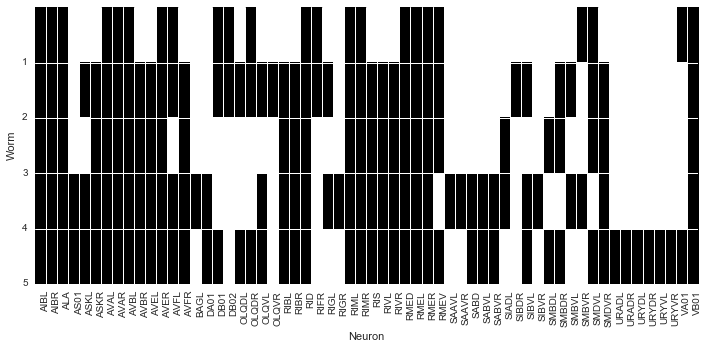

In [9]:
# Show the 60 labeled neurons that show up in one or more worms
plt.figure(figsize=(10,5))
plt.imshow(dsizes[:,:60], aspect="auto", interpolation="nearest")
plt.grid("on")
plt.xticks(np.arange(60)+0.5, all_neuron_names[:60], rotation=90)
plt.yticks(np.arange(N_worms)+0.5, np.arange(N_worms)+1)
plt.ylabel("Worm")
plt.xlabel("Neuron")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "identified_neurons.pdf"))

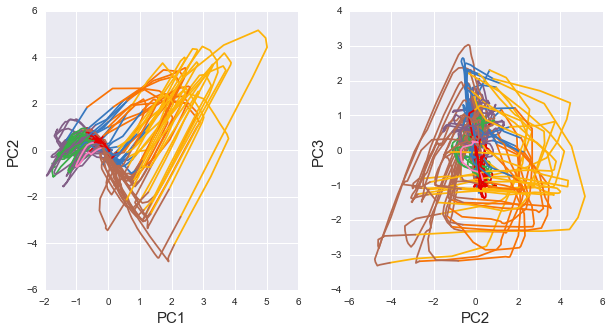

In [10]:
# Try to reproduce their plot of PC's over time
pca = PCA(n_components=3, whiten=True)
pca.fit(np.vstack(Ys_shared))
pca.explained_variance_ratio_

pca_trajs = [pca.transform(Y) for Y in Ys_shared]
pcs = pca.components_.T

plt.figure(figsize=(10,5))
zimmer_states, zimmer_cps = worm_datas[0].zimmer_states, worm_datas[0].zimmer_cps
for cp_start, cp_stop in zip(zimmer_cps[:-1], zimmer_cps[1:]):
    plt.subplot(121)
    plt.plot(pca_trajs[0][cp_start:cp_stop+1,0], 
             pca_trajs[0][cp_start:cp_stop+1,1], 
             '-', color=colors[zimmer_states[cp_start]])
    plt.subplot(122)
    plt.plot(pca_trajs[0][cp_start:cp_stop+1,1], 
             pca_trajs[0][cp_start:cp_stop+1,2], 
             '-', color=colors[zimmer_states[cp_start]])
    
plt.subplot(121)
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)

plt.subplot(122)
plt.xlabel("PC2", fontsize=15)
plt.ylabel("PC3", fontsize=15)

# Fit an SLDS to the data from all worms


In [35]:
from pybasicbayes.distributions import AutoRegression, DiagonalRegression, Gaussian, Regression
from pybasicbayes.util.text import progprint_xrange

from pyslds.models import HMMSLDS

import zimmer.states
imp.reload(zimmer.states)

import zimmer.models
imp.reload(zimmer.models)
from zimmer.models import MultiEmissionWeakLimitStickyHDPHMMSLDS

from pyslds.util import get_empirical_ar_params

import zimmer.emissions
imp.reload(zimmer.emissions)
from zimmer.emissions import HierarchicalDiagonalRegression
from zimmer.emissions import HierarchicalDiagonalRegressionFixedScale
from zimmer.emissions import HierarchicalDiagonalRegressionTruncatedScale


In [39]:
Nmax = 15          # number of latent discrete states
P = 3              # latent linear dynamics' dimension
P_in = 1           # number of input dimensions

dynamics_hypparams = \
    dict(nu_0=P+P_in+2, 
         S_0=np.eye(P), 
         M_0=np.zeros((P,P+P_in)), 
         K_0=np.eye(P+P_in), 
         affine=False)
    


# dynamics_hypparams = get_empirical_ar_params(
#     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))], 
#     dynamics_hypparams)

dynamics_distns = [
    Regression(
        A=np.hstack((0.99*np.eye(P), np.zeros((P,P_in)))), 
        sigma=np.eye(P),
        **dynamics_hypparams)
    for _ in range(Nmax)]

# One emission distribution per "neuron," where some neurons
# are observed in one worm but not another.
emission_distns = [
#     HierarchicalDiagonalRegression(1, P+P_in, N_worms) for n in range(N_neurons)
    HierarchicalDiagonalRegressionFixedScale(1, P+P_in, N_worms) for n in range(N_neurons)
#     HierarchicalDiagonalRegressionTruncatedScale(1, P+P_in, N_worms, smin=0.75, smax=1.25) for n in range(N_neurons)
]

init_dynamics_distns = [
    Gaussian(nu_0=P+2, sigma_0=3.*np.eye(P), mu_0=np.zeros(P), kappa_0=0.01)
    for _ in range(Nmax)]

model = MultiEmissionWeakLimitStickyHDPHMMSLDS(
    init_dynamics_distns=init_dynamics_distns,
    dynamics_distns=dynamics_distns,
    emission_distns=emission_distns,
    alpha=3., gamma=3.0, kappa=100., init_state_distn='uniform')

/Users/scott/Projects/pybasicbayes/pybasicbayes/util/stats.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [40]:
# Add the data
for group, (dataset, pca_traj, T) in enumerate(zip(datasets, pca_trajs, Ts)):
    model.add_data(data=dataset, group=group, inputs=np.ones((T,1)))
    model.states_list[-1].gaussian_states = pca_traj[:,:P]
model.resample_parameters()

/Users/scott/Projects/pybasicbayes/pybasicbayes/util/stats.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


In [41]:
worm_to_plot = 1

results_fname = os.path.join(results_dir, "K%d_samples.pkl" % Nmax)
if os.path.exists(results_fname):
    # Check for existing results
    with open(results_fname, "rb") as f:
        model, lls, stateseq_smpls = pickle.load(f)
        N_samples = len(stateseq_smpls)
else:
    # Fit the model with MCMC
    def update(model):
        model.resample_model()
        ll = model.log_likelihood()
        stateseq = model.stateseqs[worm_to_plot].copy()
        return ll, stateseq
    
    N_samples = 500
    smpls = [update(model) for itr in progprint_xrange(N_samples)]
    lls, stateseq_smpls = map(np.array, zip(*smpls))
    with open(results_fname, "wb") as f:
        pickle.dump((model, lls, stateseq_smpls), f, protocol=-1)



/Users/scott/Projects/pybasicbayes/pybasicbayes/util/stats.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


.........................  [  25/500,    0.80sec avg, ETA 06:22 ]
.........................  [  50/500,    0.79sec avg, ETA 05:56 ]
.........................  [  75/500,    0.76sec avg, ETA 05:23 ]
.........................  [ 100/500,    0.77sec avg, ETA 05:09 ]
.........................  [ 125/500,    0.76sec avg, ETA 04:44 ]
.........................  [ 150/500,    0.80sec avg, ETA 04:40 ]
.........................  [ 175/500,    0.78sec avg, ETA 04:15 ]
.........................  [ 200/500,    0.78sec avg, ETA 03:54 ]
.........................  [ 225/500,    0.77sec avg, ETA 03:33 ]
.........................  [ 250/500,    0.76sec avg, ETA 03:11 ]
.........................  [ 275/500,    0.76sec avg, ETA 02:50 ]
.........................  [ 300/500,    0.75sec avg, ETA 02:30 ]
.........................  [ 325/500,    0.75sec avg, ETA 02:11 ]
.........................  [ 350/500,    0.75sec avg, ETA 01:53 ]
.........................  [ 375/500,    0.75sec avg, ETA 01:34 ]
..........

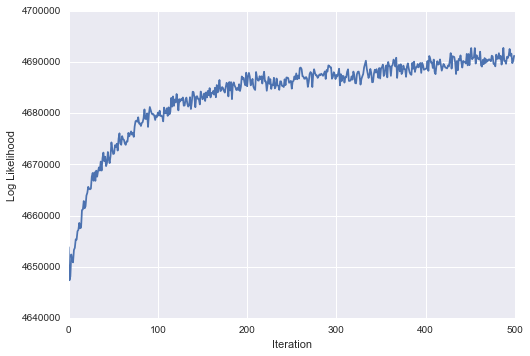

In [42]:
# Plot the log likelihood vs iteration. 
plt.figure()
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.show()

In [43]:
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation

perm_stateseq_smpls, newlabels = relabel_by_usage(stateseq_smpls, return_mapping=True)
perm_dynamics_distns = [dynamics_distns[i] for i in np.argsort(newlabels)]
np.unique(np.concatenate(perm_stateseq_smpls))
N_used = np.concatenate(perm_stateseq_smpls).max()

In [44]:
# Compute the smoothed continuous state trajectories
for states in model.states_list:
    states.info_E_step()

zs = [relabel_by_permutation(s.stateseq, newlabels) for s in model.states_list]
xs = [s.smoothed_mus for s in model.states_list]
sigma_xs = [s.smoothed_sigmas for s in model.states_list]


# Plotting 

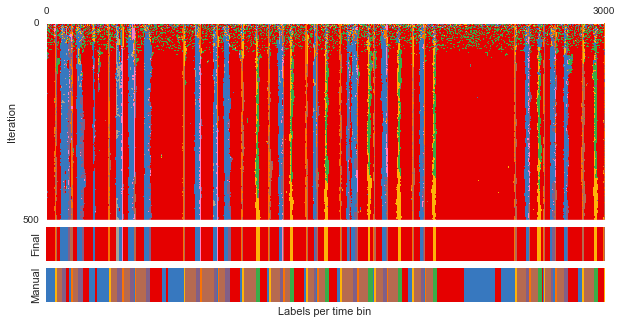

In [45]:
# Plot the true and inferred state sequences
plt_slice = (0, 3000)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(7,1)

ax1 = fig.add_subplot(gs[:-2])
ax2 = fig.add_subplot(gs[-2])
ax3 = fig.add_subplot(gs[-1])

im = ax1.matshow(perm_stateseq_smpls, aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([0, N_samples])
ax1.set_ylabel("Iteration")
ax1.set_xlim(plt_slice)
ax1.set_xticks(plt_slice)

ax2.matshow(perm_stateseq_smpls[-1][None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel("Final")
ax2.set_xlim(plt_slice)

ax3.matshow(worm_datas[0].zimmer_states[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel("Manual")
ax3.set_xlabel("Labels per time bin")
ax3.set_xlim(plt_slice)

plt.savefig(os.path.join(results_dir, "discrete_state_samples.pdf"))

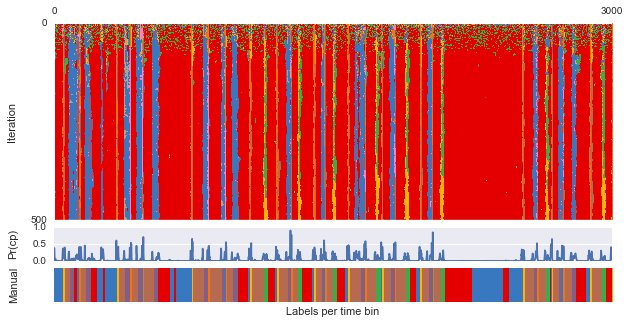

In [46]:
# Plot the true and inferred state sequences
plt_slice = (0, 3000)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(7,1)

ax1 = fig.add_subplot(gs[:-2])
ax2 = fig.add_subplot(gs[-2])
ax3 = fig.add_subplot(gs[-1])

im = ax1.matshow(perm_stateseq_smpls, aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax1.autoscale(False)
ax1.set_xticks([])
ax1.set_yticks([0, N_samples])
ax1.set_ylabel("Iteration", labelpad=13)
ax1.set_xlim(plt_slice)
ax1.set_xticks(plt_slice)

# Compute changepoint probability
ischangepoint = lambda z: np.concatenate(([0], np.diff(z) != 0))
sampled_changepoints = np.array([ischangepoint(z) for z in perm_stateseq_smpls[-250:]])
changepoint_pr = np.mean(sampled_changepoints, axis=0)
ax2.plot(changepoint_pr)
ax2.set_xticks([])
ax2.set_yticks([0,.5,1])
ax2.set_ylabel("Pr(cp)", labelpad=15)
ax2.set_xlim(plt_slice)

ax3.matshow(worm_datas[0].zimmer_states[None,:], aspect='auto', cmap=cmap, vmin=0, vmax=len(colors)-1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylabel("Manual", labelpad=35)
ax3.set_xlabel("Labels per time bin")
ax3.set_xlim(plt_slice)

plt.savefig(os.path.join(results_dir, "discrete_state_samples.pdf"))

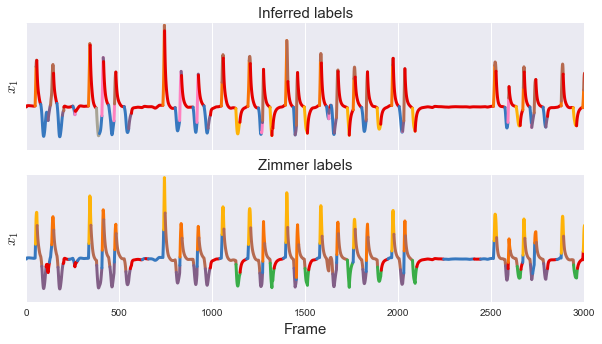

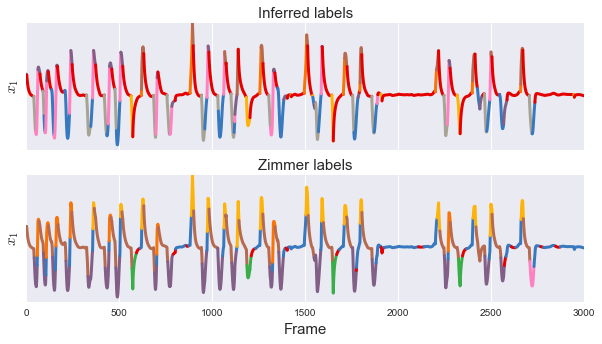

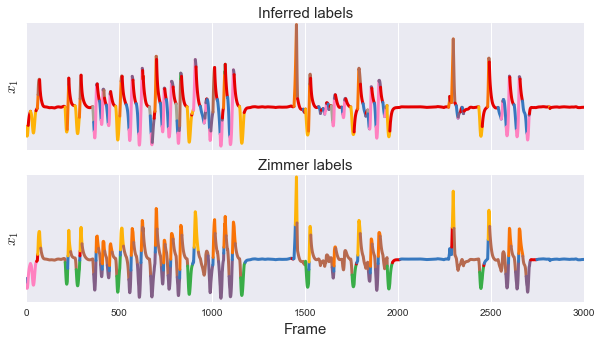

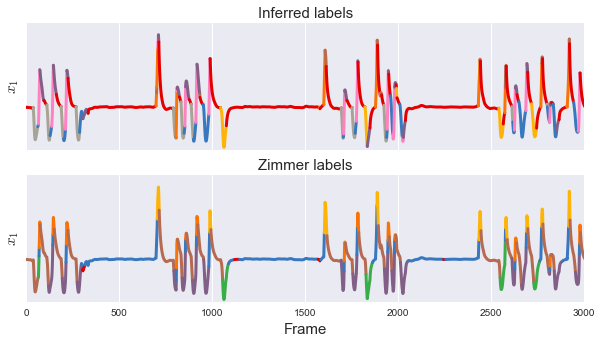

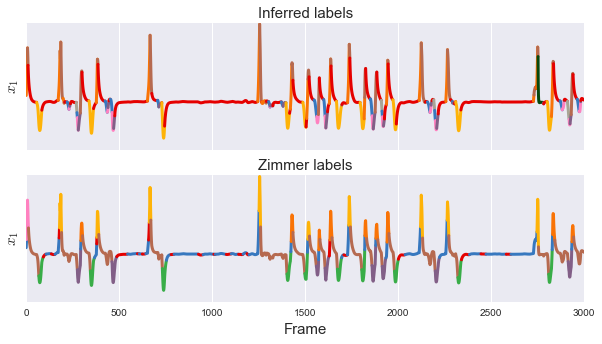

In [47]:
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states

for worm_to_plot in range(N_worms):
    plot_1d_continuous_states(xs[worm_to_plot],
                              zs[worm_to_plot],
                              worm_datas[worm_to_plot].zimmer_states,
                              x_index=0,
                              colors=colors,
                              plt_slice=plt_slice,
                              results_dir=results_dir, 
                              filename="xs_1d_worm{}_dim{}".format(worm_to_plot, 0))



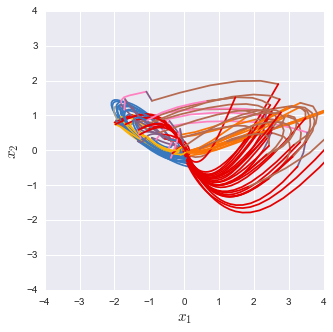

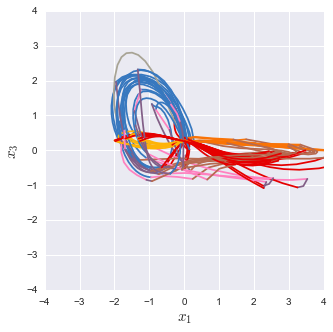

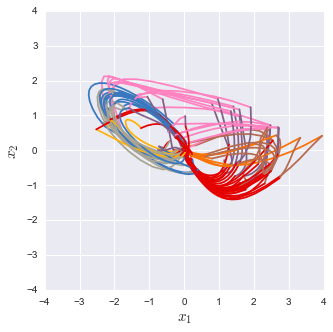

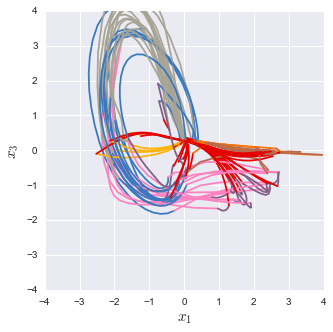

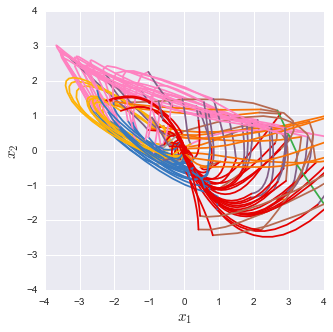

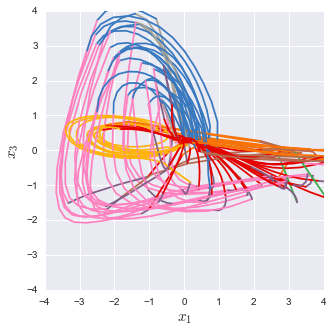

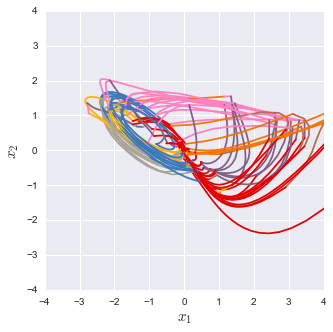

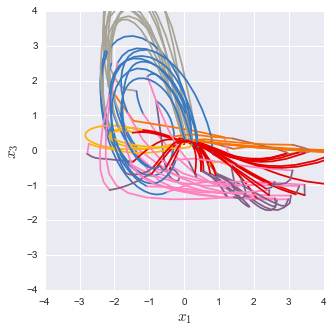

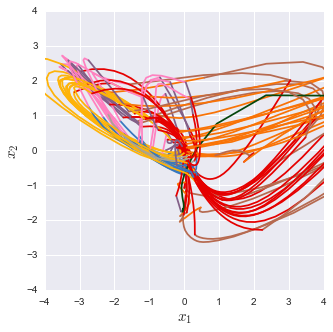

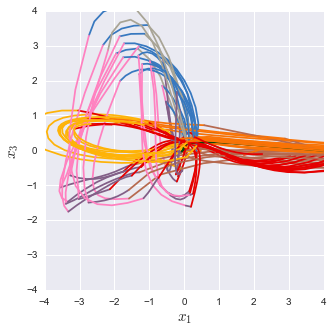

In [49]:
# Plot the inferred latent state sequence
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_2d_continuous_states

lims = (-4,4)
for worm_to_plot in range(N_worms):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plot_2d_continuous_states(ax, xs[worm_to_plot], zs[worm_to_plot], colors, inds=(0,1))
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(lims)
    plt.ylabel("$x_2$", fontsize=15)
    plt.ylim(lims)
    plt.savefig(os.path.join(results_dir, "xs_2d_worm{}_x1x2.pdf".format(worm_to_plot)))

#     ax = fig.add_subplot(222)
#     plot_2d_continuous_states(ax, xs[worm_to_plot], worm_datas[worm_to_plot].zimmer_states, colors, inds=(0,1))
#     plt.title("Kato et. al.", fontsize=15)
#     plt.xlabel("$x_1$", fontsize=15)
#     plt.xlim(-5,5)
#     plt.ylabel("$x_2$", fontsize=15)
#     plt.ylim(-5,5)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plot_2d_continuous_states(ax, xs[worm_to_plot], zs[worm_to_plot], colors, inds=(0,2))
    plt.xlabel("$x_1$", fontsize=15)
    plt.xlim(lims)
    plt.ylabel("$x_3$", fontsize=15)
    plt.ylim(lims)
    plt.savefig(os.path.join(results_dir, "xs_2d_worm{}_x1x3.pdf".format(worm_to_plot)))

#     ax = fig.add_subplot(224)
#     plot_2d_continuous_states(ax, xs[worm_to_plot], worm_datas[worm_to_plot].zimmer_states, colors, inds=(0,2))
#     plt.title("Kato et. al.", fontsize=15)
#     plt.xlabel("$x_1$", fontsize=15)
#     plt.xlim(-5,5)
#     plt.ylabel("$x_3$", fontsize=15)
#     plt.ylim(-5,5)
#     plt.savefig(os.path.join(results_dir, "xs_2d_worm{}.pdf".format(worm_to_plot)))


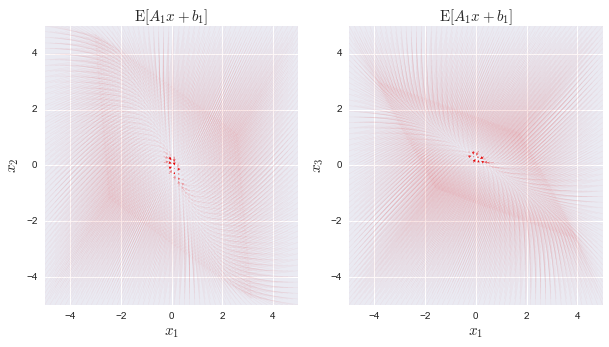

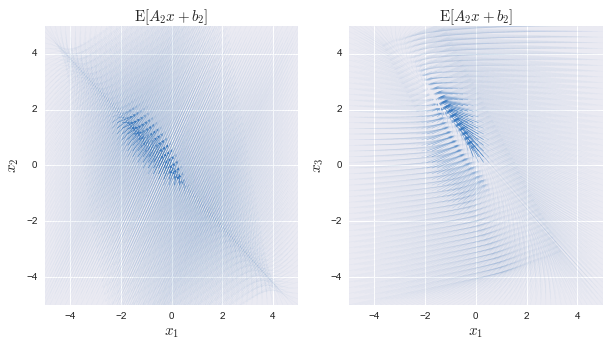

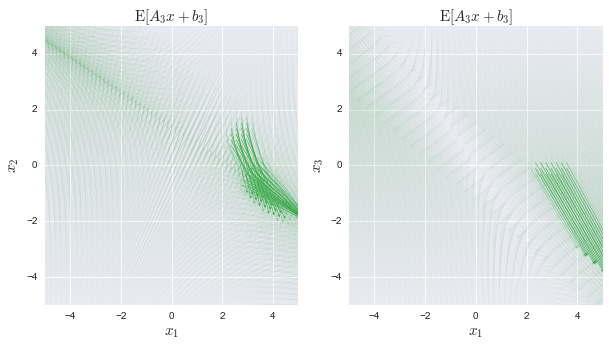

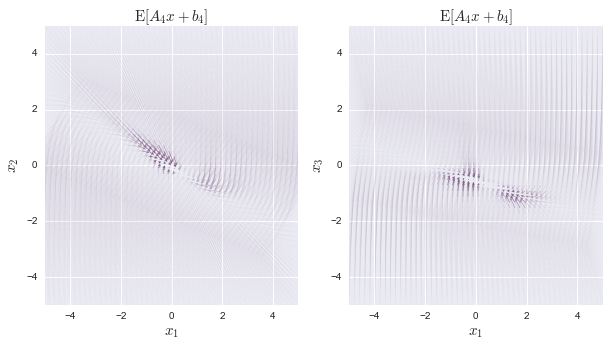

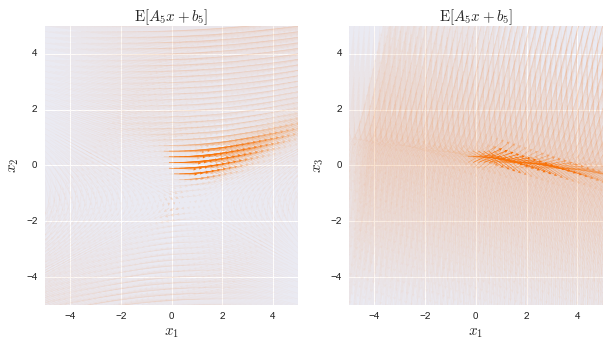

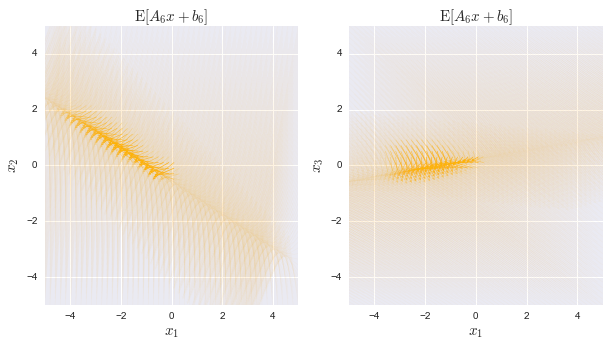

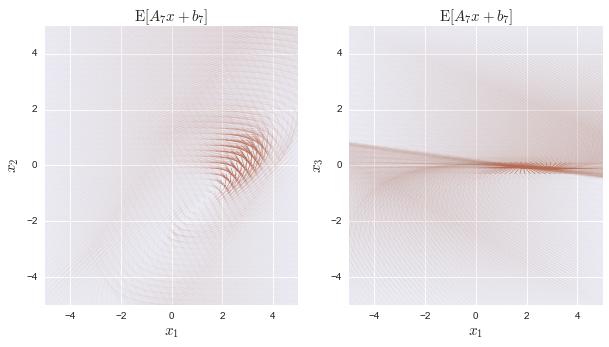

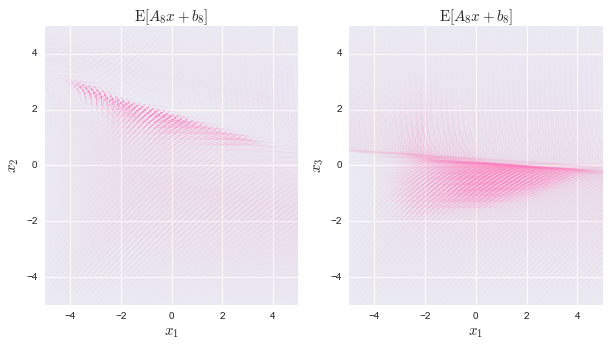

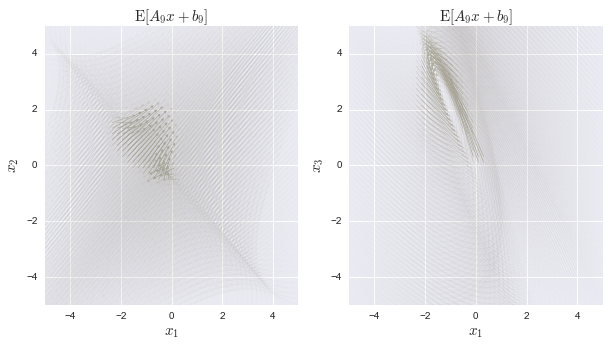

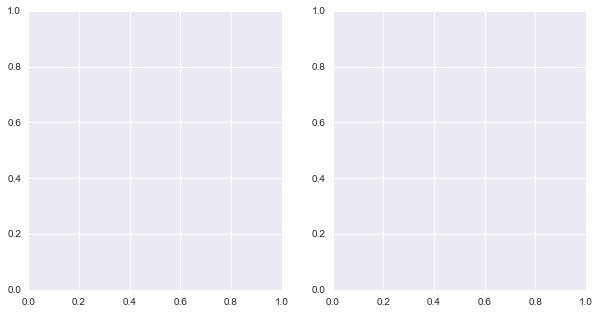

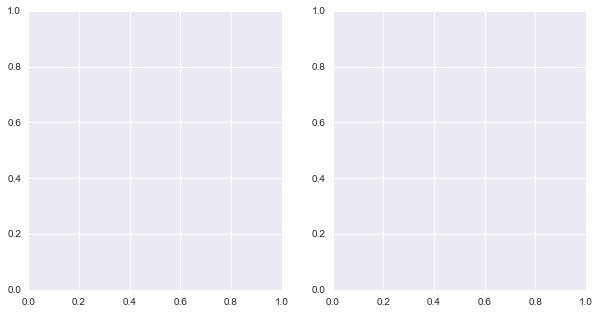

In [52]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field

for kk in range(N_used):
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(121)
    plot_vector_field(ax1, perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0),
                      kk, 
                      inds=(0,1), P_in=P_in,
                      color=np.array(colors[kk] + (1.0,)), 
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1),
                     )
    ax2 = plt.subplot(122)
    plot_vector_field(ax2, 
                      perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0), 
                      kk, 
                      inds=(0,2), P_in=P_in,
                      color=np.array(colors[kk] + (1.0,)),
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1))

    plt.savefig(os.path.join(results_dir, "vector_field_{}.pdf".format(kk)))

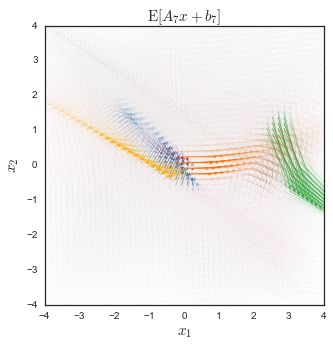

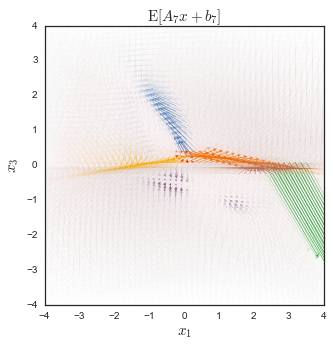

In [53]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field

sns.set_style("white")
plt.figure(figsize=(5,5))
ax1 = plt.subplot(111)
for kk in range(7):
    plot_vector_field(ax1, perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0),
                      kk, 
                      inds=(0,1), P_in=P_in,
                      color=np.array(colors[kk] + (1.0,)), 
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1),
                      alpha_offset=-5,
                      xmin=-4, xmax=4, ymin=-4, ymax=4,
                     )
plt.savefig(os.path.join(results_dir, "vector_field_overlay_1.pdf"))

plt.figure(figsize=(5,5))
ax2 = plt.subplot(111)
for kk in range(7):
    plot_vector_field(ax2, perm_dynamics_distns, 
                      np.concatenate(zs, axis=0),
                      np.concatenate(xs, axis=0),
                      np.concatenate(sigma_xs, axis=0),
                      kk, 
                      inds=(0,2), P_in=P_in,
                      color=np.array(colors[kk] + (1.0,)), 
                      title="$\\mathrm{E}[A_{%d} x + b_{%d}]$" % (kk+1, kk+1),
                      alpha_offset=-5,
                      xmin=-4, xmax=4, ymin=-4, ymax=4,
                     )
plt.savefig(os.path.join(results_dir, "vector_field_overlay_2.pdf"))



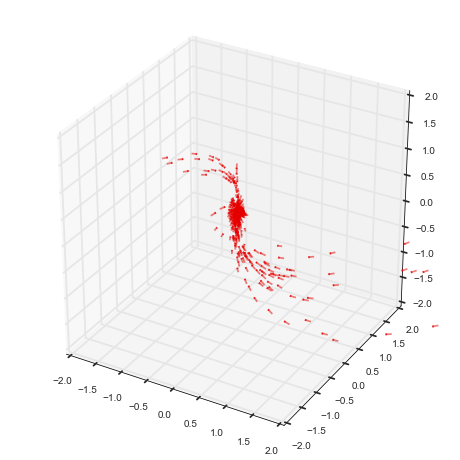

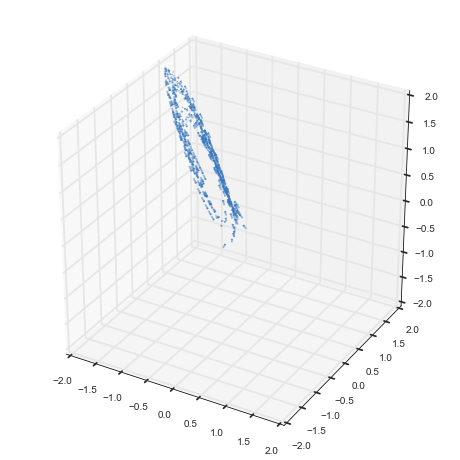

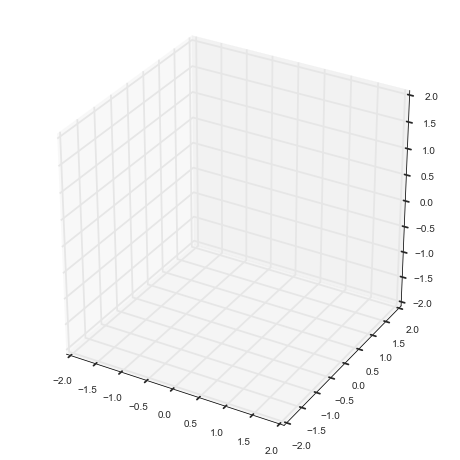

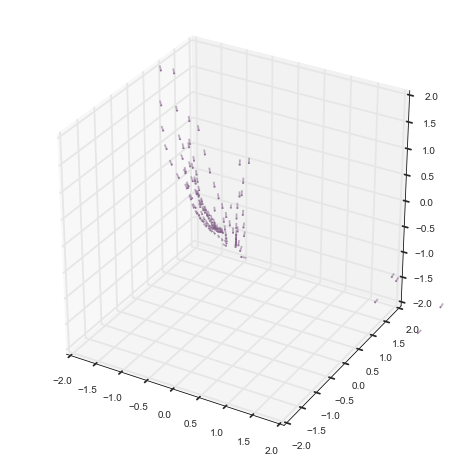

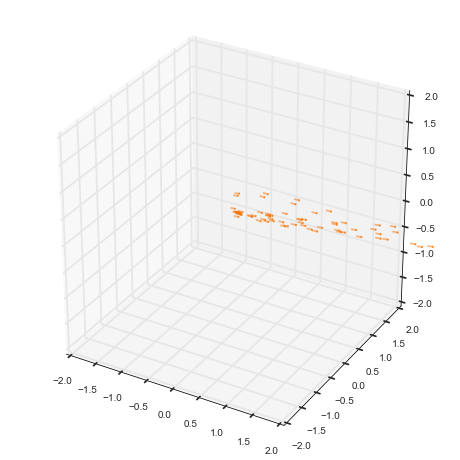

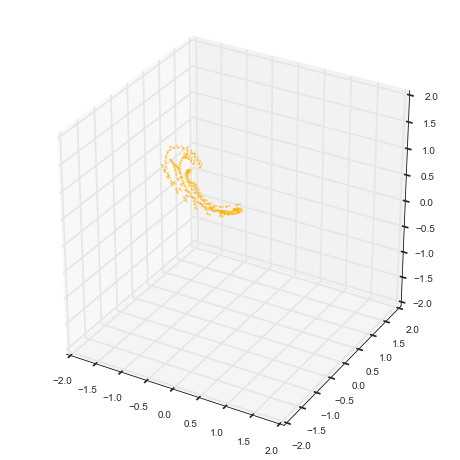

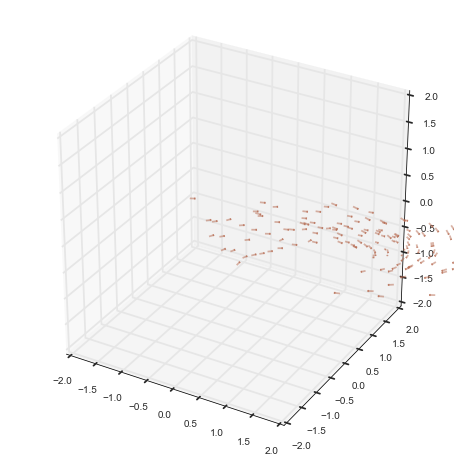

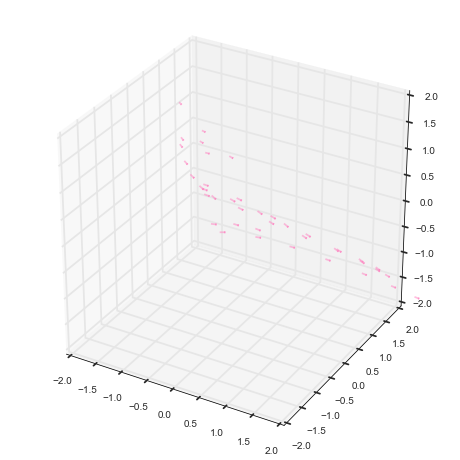

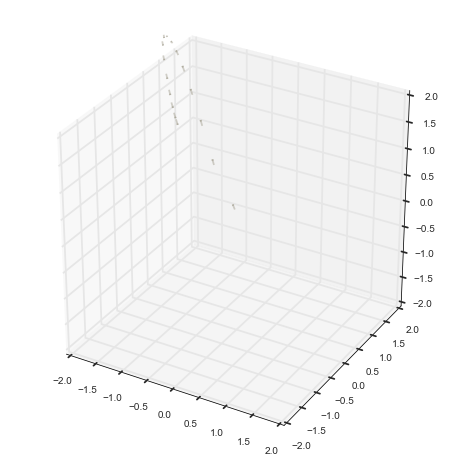

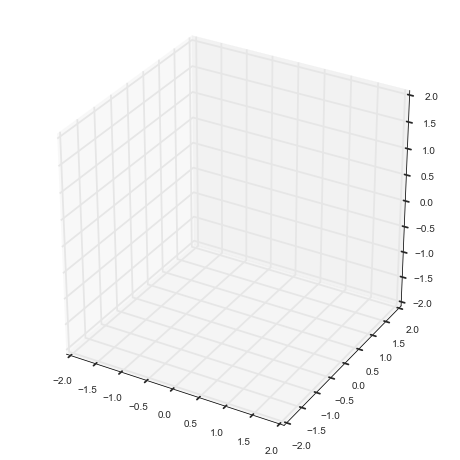

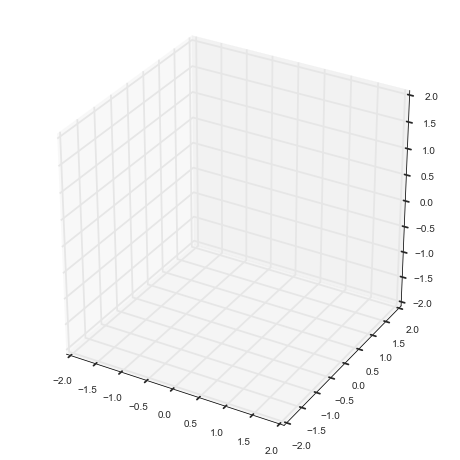

In [54]:
# Plot the vector field showing inferred (discrete-state-dependent)
# dynamics at each point in continuous latent space.
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field_3d

for ii in range(N_used):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    plot_vector_field_3d(ii, zs[0], xs[0], perm_dynamics_distns, colors, 
                         affine=(P_in==1), ax=ax, lims=(-2,2), alpha=0.5)
    
    fig.savefig(os.path.join(results_dir, "dynamics_overlay_3d_{}.pdf".format(ii)))
    

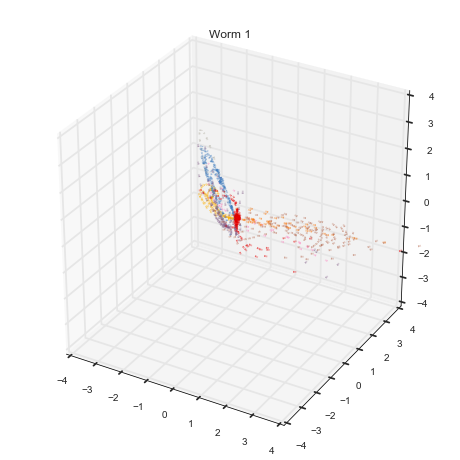

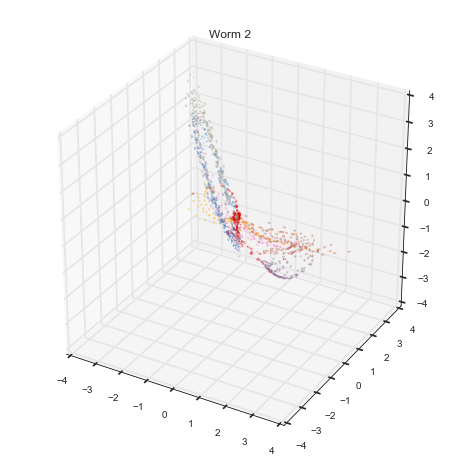

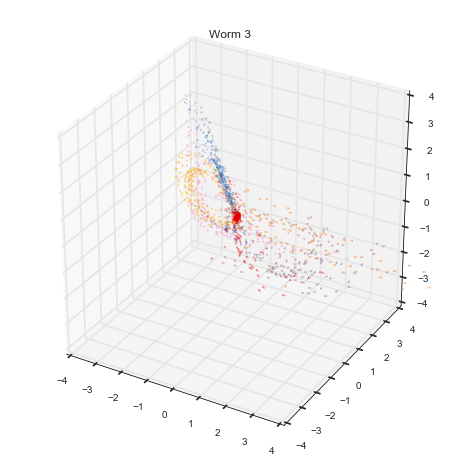

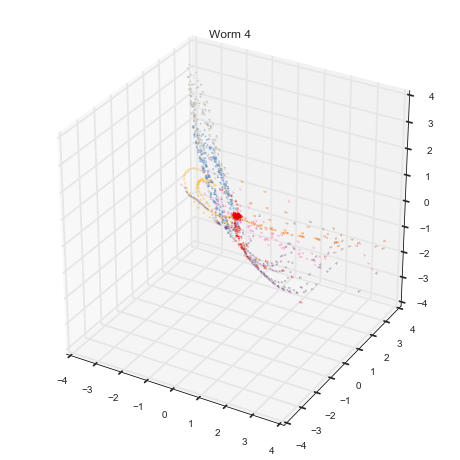

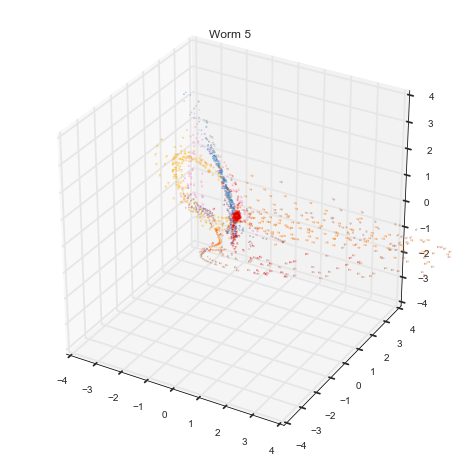

In [56]:
# Overlay them on top of each other
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field_3d

sns.set_style("white")
for worm in range(N_worms):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for ii in range(N_used):
        plot_vector_field_3d(ii, zs[worm], xs[worm], perm_dynamics_distns, colors, 
                             affine=(P_in==1), ax=ax, lims=(-4,4), alpha=0.3, N_plot=200)
    plt.title("Worm {}".format(worm+1))
    fig.savefig(os.path.join(results_dir, "dynamics_overlay_3d_worm{}.pdf".format(worm)))

.........................  [  25/360,    0.19sec avg, ETA 01:02 ]
.........................  [  50/360,    0.18sec avg, ETA 56.60 ]
.........................  [  75/360,    0.18sec avg, ETA 51.11 ]
.........................  [ 100/360,    0.18sec avg, ETA 45.84 ]
.........................  [ 125/360,    0.17sec avg, ETA 41.05 ]
.........................  [ 150/360,    0.18sec avg, ETA 36.79 ]
.........................  [ 175/360,    0.17sec avg, ETA 31.92 ]
.........................  [ 200/360,    0.17sec avg, ETA 27.26 ]
.........................  [ 225/360,    0.17sec avg, ETA 22.77 ]
.........................  [ 250/360,    0.17sec avg, ETA 18.42 ]
.........................  [ 275/360,    0.17sec avg, ETA 14.23 ]
.........................  [ 300/360,    0.17sec avg, ETA 10.05 ]
.........................  [ 325/360,    0.17sec avg, ETA 5.84 ]
.........................  [ 350/360,    0.17sec avg, ETA 1.69 ]
..........
   0.17sec avg, 01:01 total



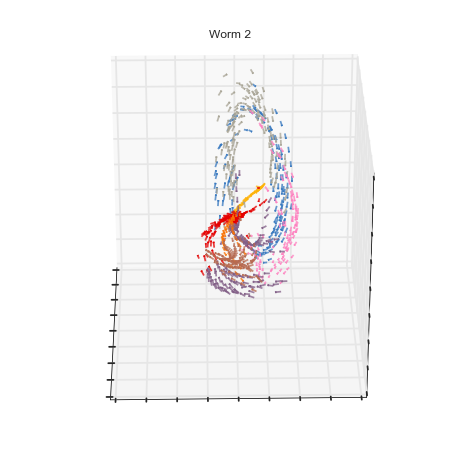

In [57]:
import matplotlib.animation as manimation
imp.reload(manimation)

import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_vector_field_3d


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='3d vector field')
writer = FFMpegWriter(fps=15, bitrate=1024, metadata=metadata)

# overlay = False
for worm in range(1,2):
    # Initialize frame
#     if not overlay:
#         fig = plt.figure(figsize=(8,5))
#         ax = fig.add_subplot(111, projection='3d')
#         ax.w_xaxis.set_pane_color([1,1,1,1])
#         ax.w_yaxis.set_pane_color([1,1,1,1])
#         ax.w_zaxis.set_pane_color([1,1,1,1])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for ii in range(N_used):
        plot_vector_field_3d(ii, zs[worm], xs[worm], perm_dynamics_distns, colors, 
                             affine=(P_in==1), ax=ax, lims=(-4,4), alpha=0.75, N_plot=150, length=.2)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    plt.title("Worm {}".format(worm+1))


#     # Initialize trajectories
#     lns = []
#     for (cp_start, cp_stop) in zip(cps[:-1], cps[1:]):
#         if zs[cp_start] == kk:
#             ln = ax.plot([xs[cp_start, 0]],
#                          [xs[cp_start, 1]],
#                          [xs[cp_start, 2]],
#                          '-', color=cmap(zs[cp_start] / float(N_used)),
#                         alpha=0.75)[0]
#         else:
#             ln = None
#         lns.append(ln)

#     # Figure out how long the durations are
#     durations = cps[1:] - cps[:-1]
#     durations = durations[zs[cps[:-1]]==kk]
#     max_duration = durations.max()
#     print "max duration for state ", kk, " = ", max_duration

#     def plot_trajectories(i, lns, delay=10, pause_between=5):
#         # Delay before plotting trajectories
#         if i < delay:
#             return

#         # Get the offset 
#         i = (i - delay) % (max_duration+pause_between)

#         for (ln, cp_start, cp_stop) in zip(lns, cps[:-1], cps[1:]):
#             dur = cp_stop - cp_start + 1
#             if i < dur:
#                 if zs[cp_start] == kk:
#                     ln.set_xdata(xs[cp_start:cp_start+i, 0])
#                     ln.set_ydata(xs[cp_start:cp_start+i, 1])
#                     ln.set_3d_properties(zs=xs[cp_start:cp_start+i,2])

    def update_frame(i):
        # Rotate the xy plane
        ax.view_init(elev=30., azim=i)

        # Plot the trajectories
#         plot_trajectories(i, lns)


    filename = os.path.join(results_dir, "dynamics_overlay_3d_worm{}.mp4".format(worm))
    with writer.saving(fig, filename, 150):
        for i in progprint_xrange(360):
            update_frame(i)
            writer.grab_frame()


/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 16196 but corresponding boolean dimension is 3239


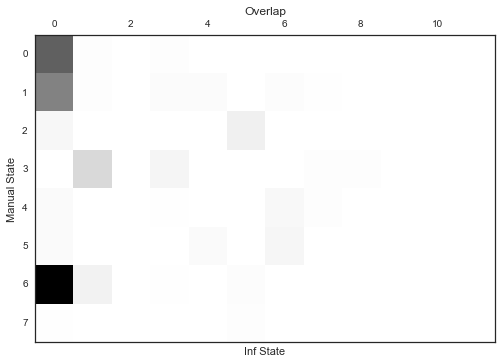

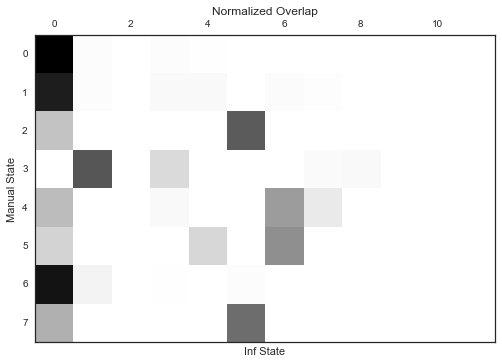

In [59]:
# Visualize the manual-inferred state overlap
N_zimmer = 8
overlap = np.zeros((N_zimmer, N_used+1))
inf_states1 = np.concatenate(zs)
for kk in range(N_zimmer):
    overlap[kk] = np.bincount(inf_states1[zimmer_states==kk], minlength=N_used+1)

normalized_overlap = overlap / (1e-3+overlap.sum(1, keepdims=True))

plt.matshow(overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Overlap")

plt.matshow(normalized_overlap, cmap="Greys")
plt.xlabel("Inf State")
plt.ylabel("Manual State")
plt.title("Normalized Overlap")

In [58]:
# Plot the transition matrix
import zimmer.plotting
imp.reload(zimmer.plotting)
from zimmer.plotting import plot_transition_matrix

P = perm_transition_matrix[:N_used, :N_used]
plot_transition_matrix(P, colors, cmap)
plt.savefig(os.path.join(results_dir, "trans_matrix.pdf"))

NameError: name 'perm_transition_matrix' is not defined

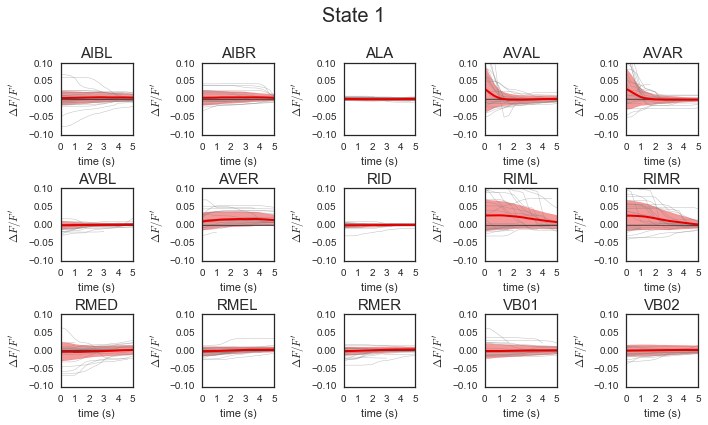

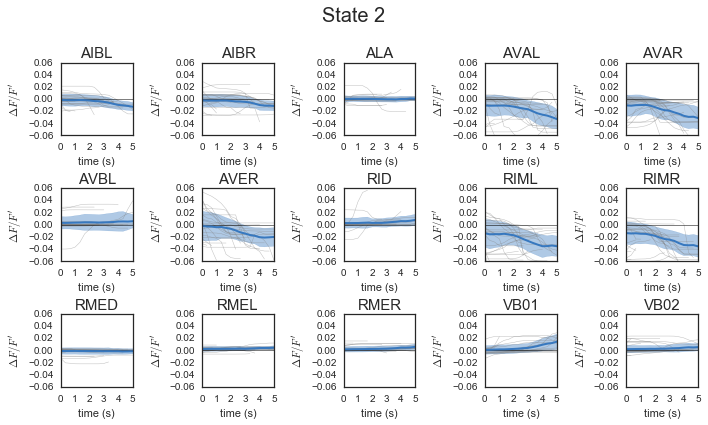

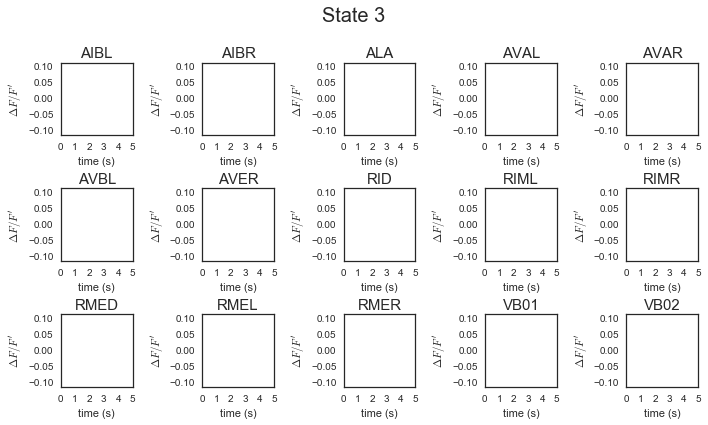

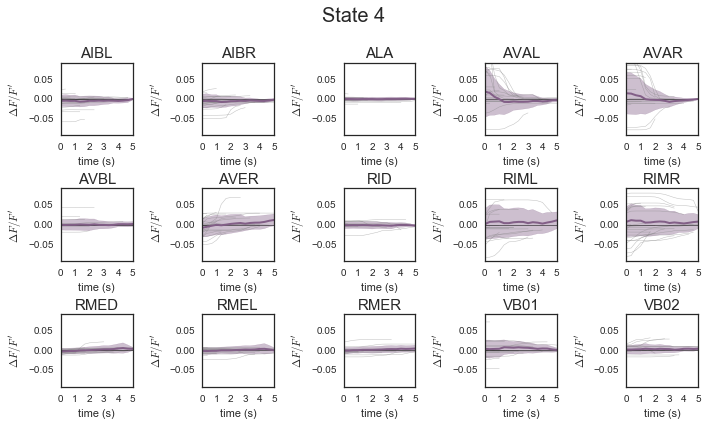

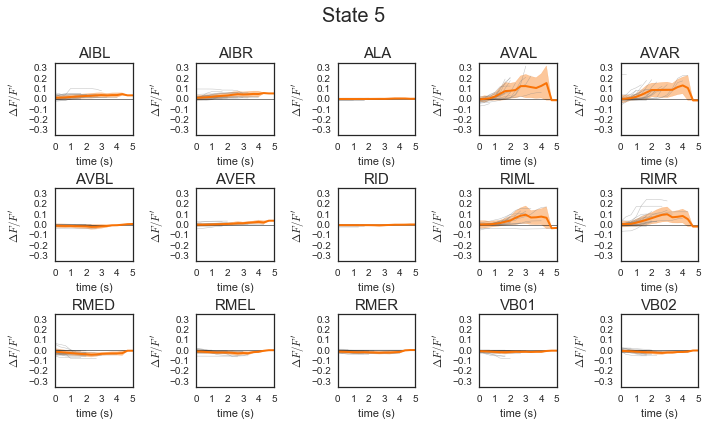

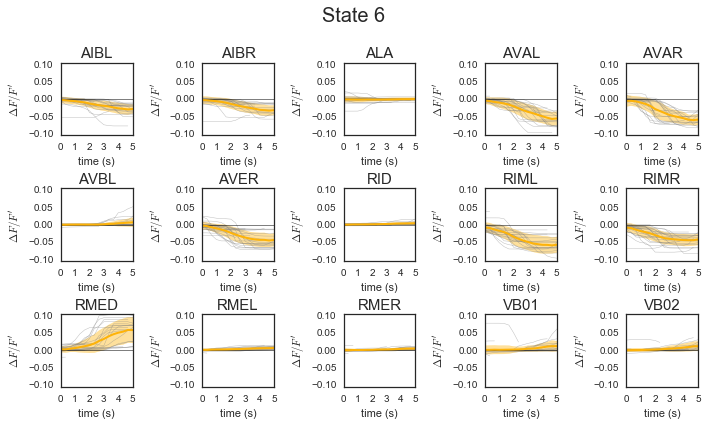

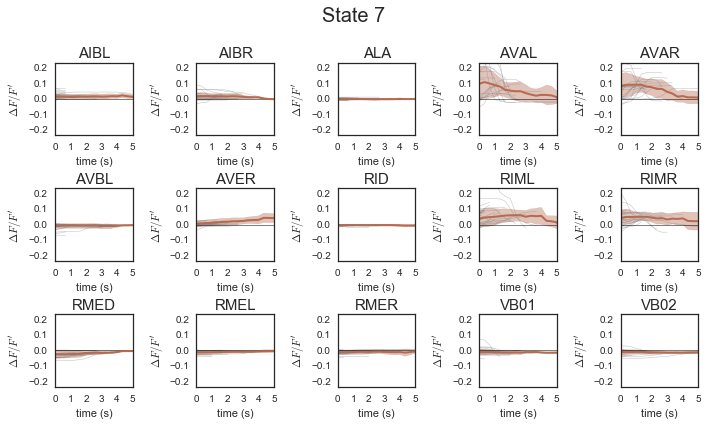

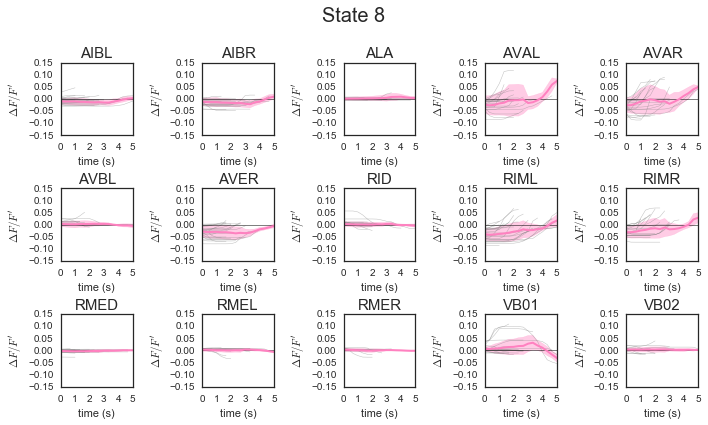

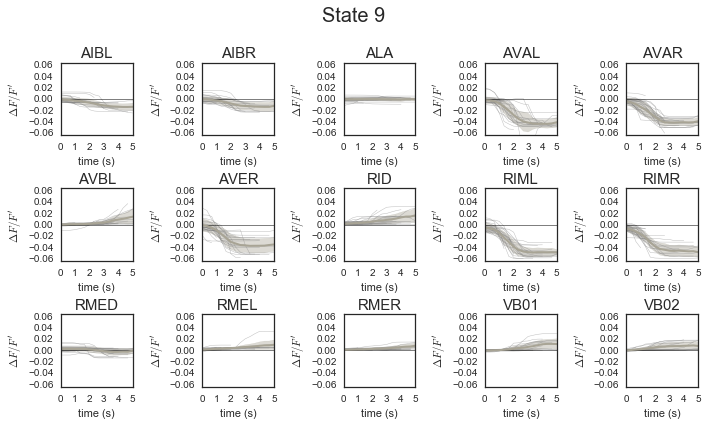

In [60]:
# Look at the average activity of the individual neurons 
# in each of the discrete states
from zimmer.util import states_to_changepoints
fs = 3.0
Y = np.vstack(Ys_shared)
z = np.concatenate(zs)
cps = states_to_changepoints(z)
cps_start, cps_stop = cps[:-1], cps[1:]
for kk in range(N_used):
# for kk in range(1):
    # Find all the instances of this state
    kk_start = cps_start[z[cps_start] == kk]
    kk_stop = cps_stop[z[cps_start] == kk]
    if len(kk_start) == 0:
        continue
        
    durs = kk_stop - kk_start
    max_dur = durs.max()
    tt = np.arange(max_dur) / fs
    
    # Find the mean of Y 
    # aligned to entry into this state
    Ysmpls = []
    Ysum = np.zeros((max_dur, N_shared))
    count = np.zeros(max_dur)
    for start,stop in zip(kk_start, kk_stop):
        Ysum[:stop-start] += Y[start:stop]
        Ysmpls.append(Y[start:stop])
        count[:stop-start] += 1
        
    Ymean = Ysum / count[:,None]
    
    # Find the variance of Y 
    # aligned to entry into this state
    Ysumsq = np.zeros((max_dur, N_shared))
    for start,stop in zip(kk_start, kk_stop):
        Ysumsq[:stop-start] += (Y[start:stop] - Ymean[:stop-start])**2
        
    Yvar = Ysumsq / count[:,None]
    Ystd = np.sqrt(Yvar)
    
    # Compute limits
    lim = 1.1 * (abs(Ymean) + Ystd).max()
    
    # Plot the average response
    from hips.plotting.sausage import sausage_plot
    fig = plt.figure(figsize=(10,6))
    for n, neuron_name in enumerate(shared_neurons):
        ax = fig.add_subplot(3,5,n+1)
        # Plot examples
        iis = np.random.choice(len(Ysmpls), size=min(25, len(Ysmpls)), replace=False)
        for ii in iis:
            yy = Ysmpls[ii]
            ax.plot(tt[:yy.shape[0]], yy[:,n], '-', color="gray", lw=0.5, alpha=0.5)
            
        # Plot the x axis
        plt.plot(tt, np.zeros_like(tt), '-k', lw=0.5)
            
        sausage_plot(tt, Ymean[:,n], Ystd[:,n], ax, color=colors[kk], alpha=0.4)
        ax.plot(tt, Ymean[:,n], '-', color=colors[kk], lw=2)
        


        ax.set_ylim(-lim, lim)
        ax.set_xlim(0,5.)
        ax.set_title(neuron_name, fontsize=15)
        ax.set_xlabel("time (s)")
        ax.set_ylabel("$\\Delta F/F'$")
        fig.suptitle("State {}".format(kk+1), fontsize=20)
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    plt.savefig(os.path.join(results_dir, "neural_responses_{}.pdf".format(kk)))